# Libraries

['XR_SHOULDER'] monitor val_accuracy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import os
import lib.data_loader as data_loader
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import matplotlib.image as mpimg
# from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import random, os
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
#%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
import gc
# from skimage.transform import resize

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed

from sklearn.metrics import f1_score, recall_score, precision_score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
#! pip install -q -U keras-tuner
import keras_tuner as kt

import json

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.0


In [2]:
from importlib import reload
reload(data_loader)

<module 'lib.data_loader' from '/tf/lib/data_loader.py'>

# Data

In [3]:
train, test, bodyparts, bodyparts_train_validation_dict, train_generators, valid_generators, test_generators = data_loader.data_loader("deep_augment")


Import train and test data


Create dictionary for training and validation set per body part

Doing a light data augmentation

Create dictionary for training, validation and test set per body part

Found 1139 validated image filenames.
Found 133 validated image filenames.
Found 288 validated image filenames.
Found 7547 validated image filenames.
Found 832 validated image filenames.
Found 563 validated image filenames.
Found 4610 validated image filenames.
Found 496 validated image filenames.
Found 461 validated image filenames.
Found 8796 validated image filenames.
Found 956 validated image filenames.
Found 659 validated image filenames.
Found 4998 validated image filenames.
Found 545 validated image filenames.
Found 460 validated image filenames.
Found 1648 validated image filenames.
Found 177 validated image filenames.
Found 301 validated image filenames.
Found 4421 validated image filenames.
Found 510 validated image filenames.
Found 465 validated image filenames.
Data munging comp

In [4]:
bodyparts

{'XR_ELBOW',
 'XR_FINGER',
 'XR_FOREARM',
 'XR_HAND',
 'XR_HUMERUS',
 'XR_SHOULDER',
 'XR_WRIST'}

# Fine tuning

In [5]:
def model_builder_cnn(hp, conv_dropout=True):

    #########################################
    ## set hyperparameters for fine tuning ##
    #########################################

    # tune the number of units
#     hp_units = hp.Int('units', min_value=32, max_value=32*8, step=32)
    
    # tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', 
                                 values=[5*1e-4, 5*1e-1, 1e-3])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    # convulational layers
    conv_layers = hp.Int('conv_blocks', 2, 5, default=3)
#     conv_layers=4
    # dropour rate
    dropout_rate = hp.Float('dropout', 0.1, 0.5, step=0.1, default=0.2)

    np.random.seed(1000) # Define the seed for numpy to have reproducible experiments.
    set_seed(150) # Define the seed for Tensorflow to have reproducible experiments.

    ###################
    ## define model ##
    ###################
    input_shape = (320,320,3)
    
    # define the input layer
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # define the convolutional layers
    # using functional api
    for i in range(conv_layers):
        # filters
#         filters = hp.Int('filters_' + str(i), 32, 224, step=32)

        x = Conv2D(
            filters=8*(2**(i+1)),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=tf.keras.layers.ReLU(),
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)

        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)

        if conv_dropout:
            x = Dropout(
                rate = dropout_rate,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)

    # flatten the convolved images 
    # fit to feed the dense layer
    x = Flatten(name='Flatten')(x)
    
    # define the output layer
    output = Dense(
        units = 1,
        activation = 'sigmoid',
        name='Output'
    )(x)

    # define the model and train it
    model_cnn = Model(inputs=input, 
                      outputs=output)

    model_cnn.compile(
                      optimizer=optimizer, 
                      loss='binary_crossentropy', 
                      metrics=['binary_accuracy'])
    
    return model_cnn
    

In [8]:
# build tuner to fine-tune the hyper-parameters
# for the model
classes=14
tuner = kt.Hyperband(
                    model_builder_cnn,
                    objective='val_binary_accuracy',
                    max_epochs=30,
                    hyperband_iterations=2,
                    directory='data/fine_tuner_1stproject_simplified',
                    project_name='base_model_30_epochs_shoulder_monitor_val_accuracy'
)

INFO:tensorflow:Reloading Oracle from existing project data/fine_tuner_1stproject_simplified/base_model_30_epochs_shoulder_monitor_val_accuracy/oracle.json


In [9]:
# define the early stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=5)

validation_steps = math.ceil(valid_generators['XR_SHOULDER'].n/ (2*valid_generators['XR_SHOULDER'].batch_size))
print("Using validation_steps = %d" % validation_steps)
steps_per_epoch = math.ceil(train_generators['XR_SHOULDER'].n / (6*train_generators['XR_SHOULDER'].batch_size))
print("Using steps_per_epoch = %d" % steps_per_epoch)
    
# perfrom search for best parameters
tuner.search(train_generators['XR_SHOULDER'], 
             validation_data=valid_generators['XR_SHOULDER'], 
             epochs=30, 
             callbacks=[stop_early])
#              validation_steps=validation_steps,
#              steps_per_epoch=steps_per_epoch)

# get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 80 Complete [00h 40m 21s]
val_binary_accuracy: 0.5504151582717896

Best val_binary_accuracy So Far: 0.7200474739074707
Total elapsed time: 01h 30m 14s
INFO:tensorflow:Oracle triggered exit


In [12]:
print('Learning rate: ', best_hps.get('learning_rate'), ', Convolutional blocks: ', best_hps.get('conv_blocks'), ', Dropout rate: ', best_hps.get('dropout'))

Learning rate:  0.0005 , Convolutional blocks:  3 , Dropout rate:  0.1


# Best model

## Build

In [13]:
# build the model with the optimal hyperparameters 
# train it on the data for 50 epochs

model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generators['XR_SHOULDER'], 
             validation_data=valid_generators['XR_SHOULDER'], 
             epochs=60, 
             callbacks=[stop_early])
#              validation_steps=validation_steps,
#              steps_per_epoch=steps_per_epoch)



Epoch 1/60
236/236 [==============================] - 231s 974ms/step - loss: 0.7065 - binary_accuracy: 0.5212 - val_loss: 0.6795 - val_binary_accuracy: 0.5967
Epoch 2/60
236/236 [==============================] - 229s 966ms/step - loss: 0.6826 - binary_accuracy: 0.5702 - val_loss: 0.6684 - val_binary_accuracy: 0.5907
Epoch 3/60
236/236 [==============================] - 228s 965ms/step - loss: 0.6791 - binary_accuracy: 0.5704 - val_loss: 0.6662 - val_binary_accuracy: 0.6026
Epoch 4/60
236/236 [==============================] - 229s 969ms/step - loss: 0.6725 - binary_accuracy: 0.5920 - val_loss: 0.6683 - val_binary_accuracy: 0.6121
Epoch 5/60
236/236 [==============================] - 230s 972ms/step - loss: 0.6660 - binary_accuracy: 0.5945 - val_loss: 0.6599 - val_binary_accuracy: 0.5979
Epoch 6/60
236/236 [==============================] - 231s 978ms/step - loss: 0.6683 - binary_accuracy: 0.5913 - val_loss: 0.6643 - val_binary_accuracy: 0.5824
Epoch 7/60
236/236 [====================

In [14]:

val_acc_per_epoch = history.history['val_binary_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Best epoch: 19


## Train

In [15]:
# instantiate the hypermodel 
# train it with the optimal number of epochs

hypermodel = tuner.hypermodel.build(best_hps)

# retrain the model
history_hypermodel = hypermodel.fit(train_generators['XR_SHOULDER'], 
                             validation_data=valid_generators['XR_SHOULDER'], 
                             epochs=best_epoch, 
                             callbacks=[stop_early],
                             validation_steps=validation_steps,
                             steps_per_epoch=steps_per_epoch)


Epoch 1/19
40/40 [==============================] - 43s 1s/step - loss: 0.7139 - binary_accuracy: 0.5173 - val_loss: 0.6930 - val_binary_accuracy: 0.5067
Epoch 2/19
40/40 [==============================] - 42s 1s/step - loss: 0.6924 - binary_accuracy: 0.5320 - val_loss: 0.6871 - val_binary_accuracy: 0.5759
Epoch 3/19
40/40 [==============================] - 42s 1s/step - loss: 0.6921 - binary_accuracy: 0.4996 - val_loss: 0.6905 - val_binary_accuracy: 0.5804
Epoch 4/19
40/40 [==============================] - 41s 1s/step - loss: 0.6886 - binary_accuracy: 0.5699 - val_loss: 0.6895 - val_binary_accuracy: 0.5469
Epoch 5/19
40/40 [==============================] - 41s 1s/step - loss: 0.6862 - binary_accuracy: 0.5566 - val_loss: 0.6867 - val_binary_accuracy: 0.5603
Epoch 6/19
40/40 [==============================] - 42s 1s/step - loss: 0.6870 - binary_accuracy: 0.5429 - val_loss: 0.6805 - val_binary_accuracy: 0.5759
Epoch 7/19
40/40 [==============================] - 42s 1s/step - loss: 0.68

In [16]:
# plot summary
hypermodel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 320, 320, 16)      448       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 160, 160, 16)      0         
_________________________________________________________________
Dropout-1 (Dropout)          (None, 160, 160, 16)      0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 160, 160, 32)      4640      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 80, 80, 32)        0         
_________________________________________________________________
Dropout-2 (Dropout)          (None, 80, 80, 32)        0   

In [18]:
# save model

hypermodel.save("data/models/finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_best_epoch.h5")
import json
with open("data/history/history_finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_best_epoch.json", "w") as file:
    json.dump(history_hypermodel.history, file)

In [19]:
# save model

model.save("data/models/finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_60epochs.h5")
import json
with open("data/history/history_finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_60epochs.json", "w") as file:
    json.dump(history.history, file)

## Plots

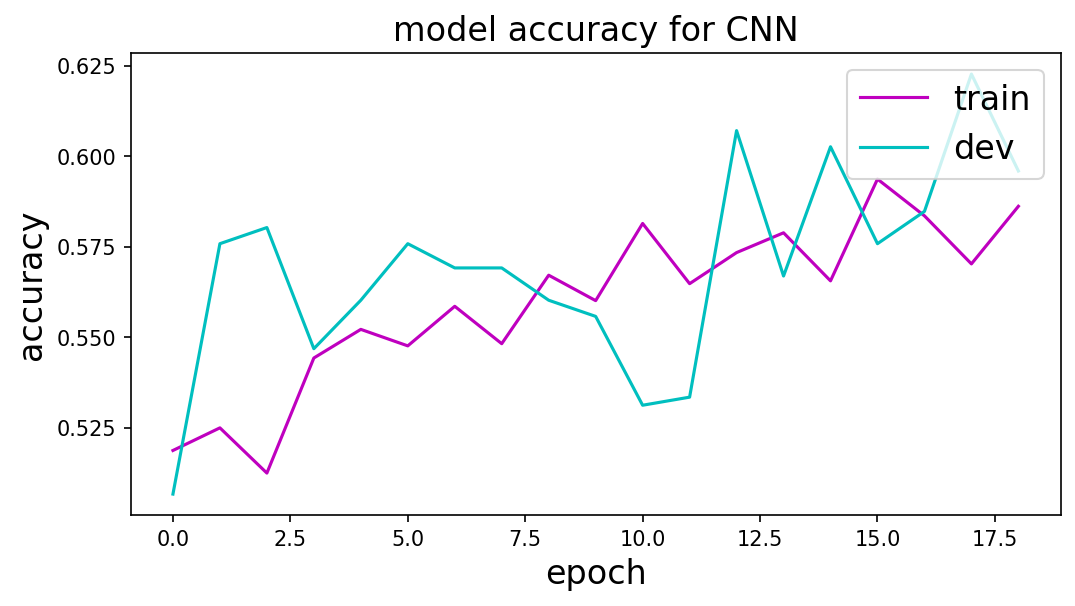

In [20]:
fig  = plt.figure(figsize=(8,4), dpi = 150)

# summarize history for accuracy
plt.plot(history_hypermodel.history['binary_accuracy'], c = 'm')
plt.plot(history_hypermodel.history['val_binary_accuracy'], c = 'c')
plt.title('model accuracy for CNN', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['train', 'dev'], loc='upper right', fontsize=16)
plt.savefig('data/plots/accuracy_finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_30epochs.png')
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

plt.show()

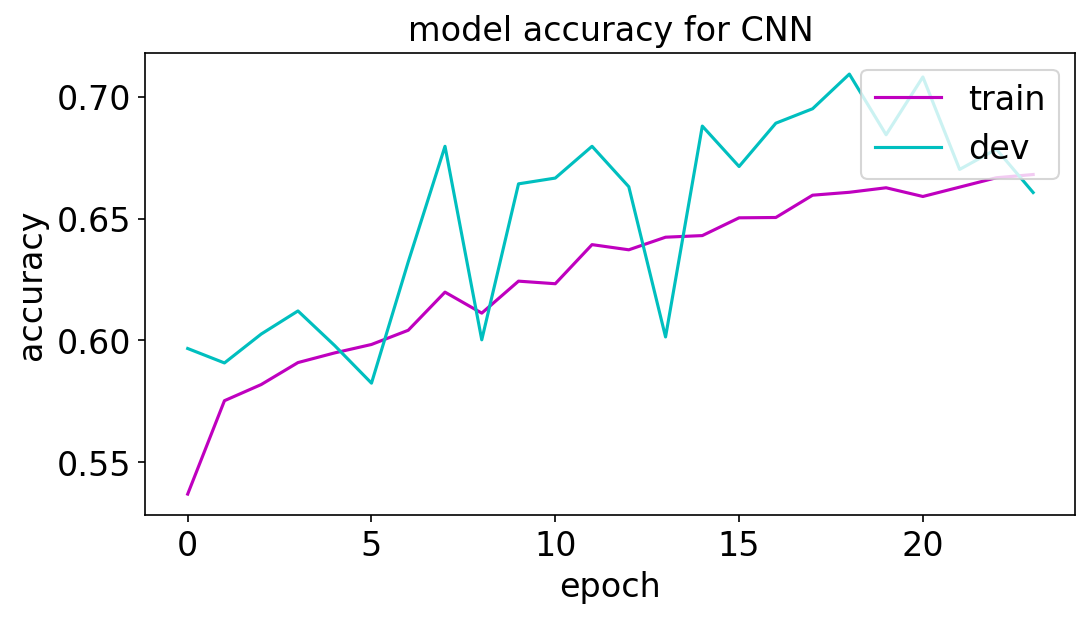

In [21]:
fig  = plt.figure(figsize=(8,4), dpi = 150)

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'], c = 'm')
plt.plot(history.history['val_binary_accuracy'], c = 'c')
plt.title('model accuracy for CNN', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['train', 'dev'], loc='upper right', fontsize=16)
plt.savefig('data/plots/accuracy_finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_allepochs.png')
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

plt.show()

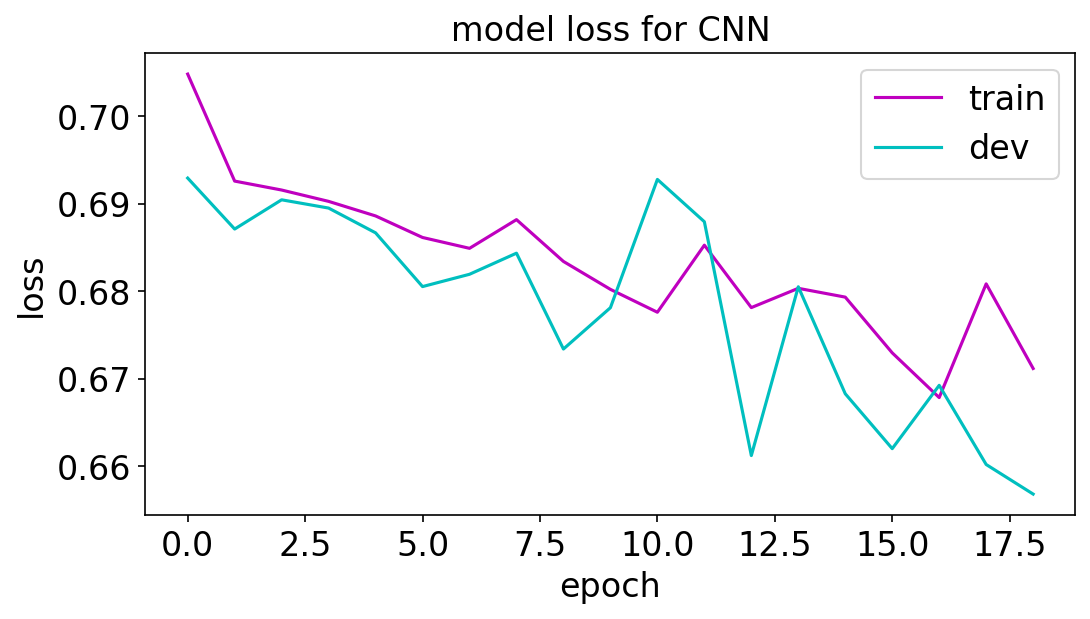

In [22]:
fig  = plt.figure(figsize=(8,4), dpi = 150)

# summarize history for loss
plt.plot(history_hypermodel.history['loss'], c = 'm')
plt.plot(history_hypermodel.history['val_loss'], c = 'c')
plt.title('model loss for CNN', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['train', 'dev'], loc='upper right', fontsize=16)
plt.savefig('data/plots/loss_finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_30epochs.png')
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

plt.show()

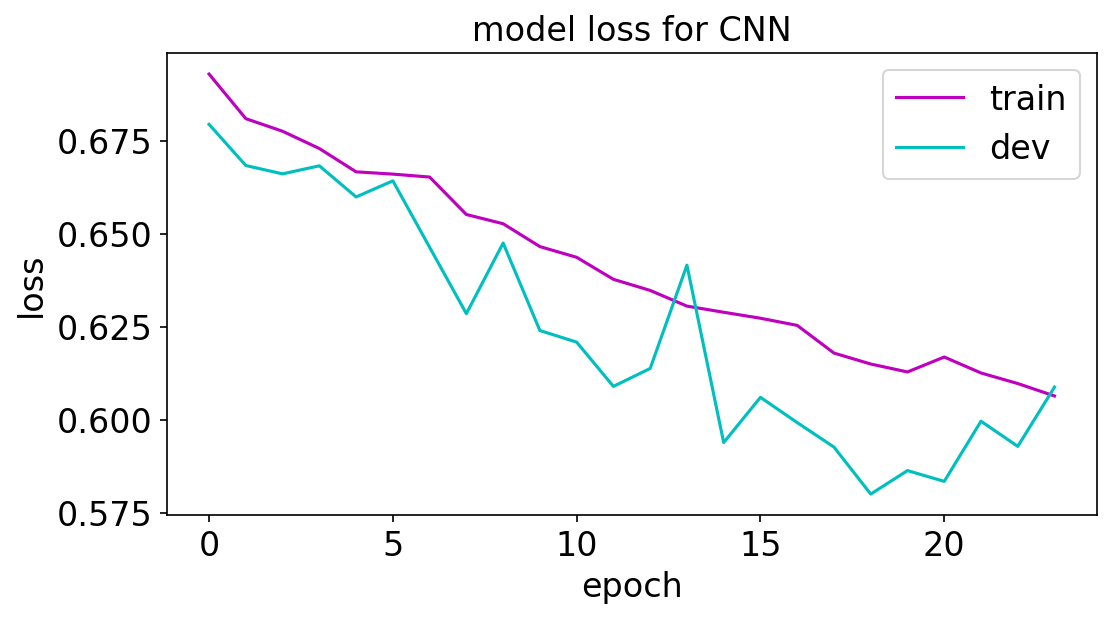

In [23]:
fig  = plt.figure(figsize=(8,4), dpi = 150)

# summarize history for loss
plt.plot(history.history['loss'], c = 'm')
plt.plot(history.history['val_loss'], c = 'c')
plt.title('model loss for CNN', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['train', 'dev'], loc='upper right', fontsize=16)
plt.savefig('data/plots/loss_finetuned_deep_augment_XR_SHOULDER_monitor_val_accuracy_allepochs.png')
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

plt.show()

## Evaluate

In [24]:
# evaluate the model
eval_result = hypermodel.evaluate(test_generators['XR_SHOULDER'])
print("test_generators, [test loss, test accuracy]:", eval_result)
eval_result2 = hypermodel.evaluate(train_generators['XR_SHOULDER'])
print("train_generators, [test loss, test accuracy]:", eval_result2)
eval_result3 = hypermodel.evaluate(valid_generators['XR_SHOULDER'])
print("valid_generators, [test loss, test accuracy]:", eval_result3)

18/18 [==============================] - 3s 176ms/step - loss: 0.6521 - binary_accuracy: 0.6377
test_generators, [test loss, test accuracy]: [0.6521139740943909, 0.6376554369926453]
236/236 [==============================] - 173s 734ms/step - loss: 0.6715 - binary_accuracy: 0.5909
train_generators, [test loss, test accuracy]: [0.6714584231376648, 0.5908970236778259]
27/27 [==============================] - 5s 169ms/step - loss: 0.6501 - binary_accuracy: 0.6204
valid_generators, [test loss, test accuracy]: [0.6500638723373413, 0.6204033493995667]


In [25]:
# evaluate the model
eval_result = model.evaluate(test_generators['XR_SHOULDER'])
print("test_generators, [test loss, test accuracy]:", eval_result)
eval_result2 = model.evaluate(train_generators['XR_SHOULDER'])
print("train_generators, [test loss, test accuracy]:", eval_result2)
eval_result3 = model.evaluate(valid_generators['XR_SHOULDER'])
print("valid_generators, [test loss, test accuracy]:", eval_result3)

18/18 [==============================] - 3s 169ms/step - loss: 0.5981 - binary_accuracy: 0.6590
test_generators, [test loss, test accuracy]: [0.598124623298645, 0.6589698195457458]
236/236 [==============================] - 173s 731ms/step - loss: 0.6078 - binary_accuracy: 0.6555
train_generators, [test loss, test accuracy]: [0.6078492999076843, 0.6555201411247253]
27/27 [==============================] - 5s 170ms/step - loss: 0.6088 - binary_accuracy: 0.6607
valid_generators, [test loss, test accuracy]: [0.6087932586669922, 0.6607354879379272]


In [26]:
def eval_func(y_true, y_prob):
    """
    A function calculating the different evaluation metrics on the test set.
    Converts prediction probabilities y_prob to predicted labels y_pred
    """
    y_pred = np.array([1 if prob >= 0.5 else 0 for prob in y_prob])
    y_true = np.array(y_true)

    print(f"Test accuracy: {round(accuracy_score(y_true, y_pred)*100, 2)} %")
    print(f"Test F1 score: {round(f1_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Precision score: {round(precision_score(y_true, y_pred)*100, 2)} %")
    print(f"Test Recall score: {round(recall_score(y_true, y_pred)*100, 2)} %")

In [29]:
eval_func(test[test['bodypart'] == 'XR_SHOULDER']['class'], 
          hypermodel.predict(test_generators['XR_SHOULDER']))

Test accuracy: 50.27 %
Test F1 score: 51.56 %
Test Precision score: 49.67 %
Test Recall score: 53.6 %


In [30]:
eval_func(test[test['bodypart'] == 'XR_SHOULDER']['class'], 
          model.predict(test_generators['XR_SHOULDER']))

Test accuracy: 48.13 %
Test F1 score: 52.13 %
Test Precision score: 47.89 %
Test Recall score: 57.19 %
